# Data Exploration for a Machine Learning Stock Predictor

In [43]:
# import needed libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Helper functions


In [44]:
def normalize_data(df):
    return df/df.ix[0,:]

# returns the desired OS path
def path_to_data(ticker, base_dir='data'):
    return os.path.join(base_dir, '{}.csv'.format(ticker))

# fetch data based on dates and tickers
def fetch_data(ticker_list, dates):
    df = pd.DataFrame(index=dates)
    
    for ticker in range(0, len(ticker_list)):
        df_temp = pd.read_csv(
            path_to_data(ticker_list[ticker]), 
            usecols=['Date', 'Adj Close'], 
            index_col='Date', 
            parse_dates=True, 
            na_values=['nan'])
        df_temp = df_temp.rename(columns={'Adj Close' : ticker_list[ticker]})
        df = df.join(df_temp)
    
    df = df.dropna(subset=['SPY'])
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)
    return df

# Helper function to grab the min and max date from a date col in a df
def get_date_range(df, col):
    return df[col].min(), df[col].max()

# Helper function to plot
def plot_data(df, title='Stock Prices'):
    ax = df.plot(title=title, fontsize=10)
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    plt.show()

In [45]:
# use two years of dates for data exploration
dates = pd.date_range('2015-07-14', '2017-07-14')

# These will be the tickers we will be working with to build our model
# SPY is added as a benchmark model. 
tickers = ['GOOG', 'AAPL', 'NVDA', 'IBM', 'SPY']

# fetch the data for the dates and tickers selected
df_explore = fetch_data(tickers, dates)
print 'Total days traded during dates: ' + str(len(df_explore))
df_explore.head(n=5)

Total days traded during dates: 506


,GOOG,AAPL,NVDA,IBM,SPY
2015-07-14,561.099976,125.610001,19.889999,168.610001,210.679993
2015-07-15,560.219971,126.820000,19.750000,168.529999,210.610001
2015-07-16,579.849976,128.509995,20.190001,171.000000,212.300003
2015-07-17,672.929993,129.619995,20.070000,172.509995,212.479996
2015-07-20,663.020020,132.070007,19.700001,173.220001,212.589996


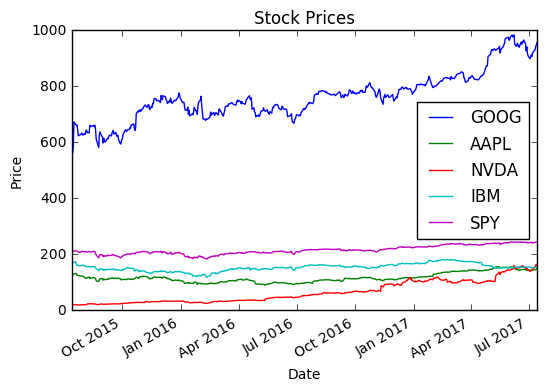

In [46]:
plot_data(df_explore)

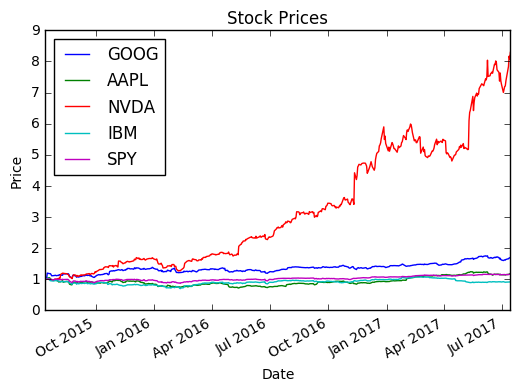

In [47]:
normalized_data = normalize_data(df_explore)
plot_data(normalized_data)

In [48]:
print 'Global Mean:\n' + str(normalized_data.mean()) + '\n'
print 'Global Median:\n' + str(normalized_data.median()) + '\n'
print 'Global Std:\n' + str(normalized_data.std()) + '\n'

Global Mean:
GOOG    1.357082
AAPL    0.927906
NVDA    3.246513
IBM     0.910470
SPY     1.021891
dtype: float64

Global Median:
GOOG    1.347870
AAPL    0.899809
NVDA    2.654098
IBM     0.909703
SPY     1.008686
dtype: float64

Global Std:
GOOG    0.154974
AAPL    0.134810
NVDA    1.982375
IBM     0.078761
SPY     0.072933
dtype: float64



## Rolling Stats

In [49]:
# def get_rolling_mean(branch, win):
    

IndentationError: expected an indented block (<ipython-input-49-1e3b842920c9>, line 2)